In [1]:
from pydrake.all import (
    HPolyhedron,
    VPolytope,
    RandomGenerator,
)
import numpy as np
import matplotlib.pyplot as plt

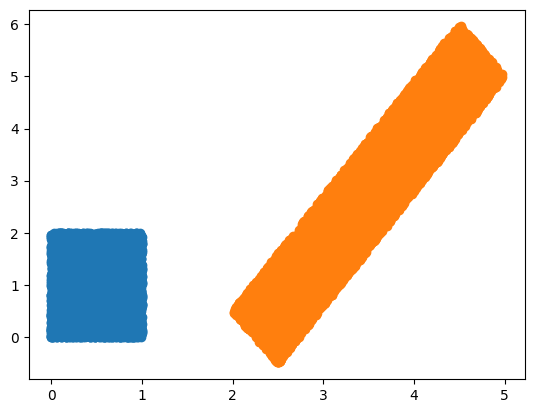

In [2]:
def get_samples(set, n_samples=100):
    samples = []
    generator = RandomGenerator()
    try:
        samples.append(set.UniformSample(generator))
        for i in range(n_samples - 1):
            samples.append(
                set.UniformSample(generator, previous_sample=samples[-1])
            )
    except:
        print("Warning: failed to sample convex set")
    return samples

x_vert = np.array([[0,0], [1,0], [1,2], [0,2]])
y_vert = np.array([[2,0.5], [2.5,-0.5], [5,5], [4.5,6]])
X_poly = HPolyhedron(VPolytope(vertices=x_vert.T))
Y_poly = HPolyhedron(VPolytope(vertices=y_vert.T))
# Plot samples using matplotlib
X_samples = get_samples(X_poly, 10000)
plt.scatter([x[0] for x in X_samples], [x[1] for x in X_samples])
Y_samples = get_samples(Y_poly, 10000)
plt.scatter([x[0] for x in Y_samples], [x[1] for x in Y_samples])

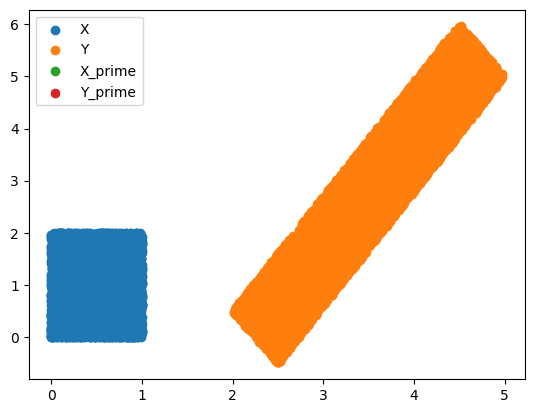

In [3]:
# 0Xx + 1Xy + 0Yx + -1Yy <= 0
# 0Xx + -1Xy + 0Yx + 1Yy <= 0
A_cX = np.array([[0, 1],[0, -1]])
A_cY = np.array([[0, -1],[0, 1]])
C_c = np.array([0,0])

A = np.vstack((X_poly.A(), np.zeros_like(Y_poly.A()), A_cX))
B = np.vstack((np.zeros_like(X_poly.A()), Y_poly.A(), A_cY))
C = np.hstack((X_poly.b(), Y_poly.b(), C_c))

# Projection Cone Z (Onto Y Space)
A_Zy = np.vstack((A.T, -A.T, -np.eye(A.shape[0]), np.eye(A.shape[0])))
b_Zy = np.hstack((np.zeros(A.T.shape[0] * 2 + A.shape[0]), np.ones(A.shape[0])*100000))
# Projection Cone Z (Onto X Space)
A_Zx = np.vstack((B.T, -B.T, -np.eye(B.shape[0]), np.eye(B.shape[0])))
b_Zx = np.hstack((np.zeros(B.T.shape[0] * 2 + B.shape[0]), np.ones(B.shape[0])*100000))
Zx_poly = HPolyhedron(A_Zx, b_Zx)
Zy_poly = HPolyhedron(A_Zy, b_Zy)
vi_y = VPolytope(Zy_poly).vertices()
vi_x = VPolytope(Zx_poly).vertices()

# Step 3: Orthogonal projection of the combined set into the Y space
A_Zy = vi_y.T @ B
b_Zy = vi_y.T @ C
# Orthogonal projection of the combined set into the X space
A_Zx = vi_x.T @ A
b_Zx = vi_x.T @ C

Y_prime_poly = HPolyhedron(A_Zy, b_Zy)
X_prime_poly = HPolyhedron(A_Zx, b_Zx)

plt.scatter([x[0] for x in X_samples], [x[1] for x in X_samples], label="X")
plt.scatter([x[0] for x in Y_samples], [x[1] for x in Y_samples], label="Y")
X_prime_samples = get_samples(X_prime_poly, 10000)
plt.scatter([x[0] for x in X_prime_samples], [x[1] for x in X_prime_samples], label="X_prime")
Y_prime_samples = get_samples(Y_prime_poly, 10000)
plt.scatter([x[0] for x in Y_prime_samples], [x[1] for x in Y_prime_samples], label="Y_prime")

plt.legend()


In [4]:
print(f"Y' contained in Y: {Y_prime_poly.ContainedIn(Y_poly, tol=10)}")
print(f"Y contained in Y': {Y_poly.ContainedIn(Y_prime_poly)}")
print(f"Y contained in Y: {Y_poly.ContainedIn(Y_poly)}")

Y' contained in Y: True
Y contained in Y': False
Y contained in Y: True


In [5]:
Y_prime_reduced_poly = Y_prime_poly
last_size = Y_prime_reduced_poly.b().size
print(f"size: {last_size}, Y' contained in Y: {Y_prime_reduced_poly.ContainedIn(Y_poly)}")
for i in range(5):
    Y_prime_reduced_poly = Y_prime_reduced_poly.ReduceInequalities()
    last_size = Y_prime_reduced_poly.b().size
    print(f"size: {last_size}, Y' contained in Y: {Y_prime_reduced_poly.ContainedIn(Y_poly)}")


size: 269, Y' contained in Y: True
size: 269, Y' contained in Y: True
size: 269, Y' contained in Y: True
size: 269, Y' contained in Y: True
size: 269, Y' contained in Y: True
size: 269, Y' contained in Y: True


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_halfspaces(A, b):
    """
    Plots the halfspaces defined by the inequality Ax <= b.

    :param A: 2D numpy array representing the matrix A.
    :param b: 1D numpy array representing the vector b.
    """

    # Define the range for x-axis. This can be adjusted based on the specific problem.
    x_range = np.linspace(0, 10, 400)
    alpha = 0.02
    # Setting up the plot
    plt.figure(figsize=(8, 8))
    
    for row, bi in zip(A, b):
        # Calculating the y values for the line. Avoid division by zero.
        if row[1] != 0:
            y_values = (bi - row[0] * x_range) / row[1]
        else:
            # If the second element of the row is zero, plot a vertical line.
            x_values = np.full_like(x_range, bi / row[0])
            plt.plot(x_values, x_range, '-r')
            plt.fill_betweenx(x_range, x_values, x_values + 100, color='red', alpha=alpha)
            continue

        # Plot the line
        plt.plot(x_range, y_values, '-r')

        # Fill the half-space
        if row[1] > 0:
            plt.fill_between(x_range, y_values, y_values + 100, color='red', alpha=alpha)
        else:
            plt.fill_between(x_range, y_values, y_values - 100, color='red', alpha=alpha)

    plt.xlim(0, 10)
    plt.ylim(-5, 10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title('Halfspaces defined by Ax <= b')
    plt.show()


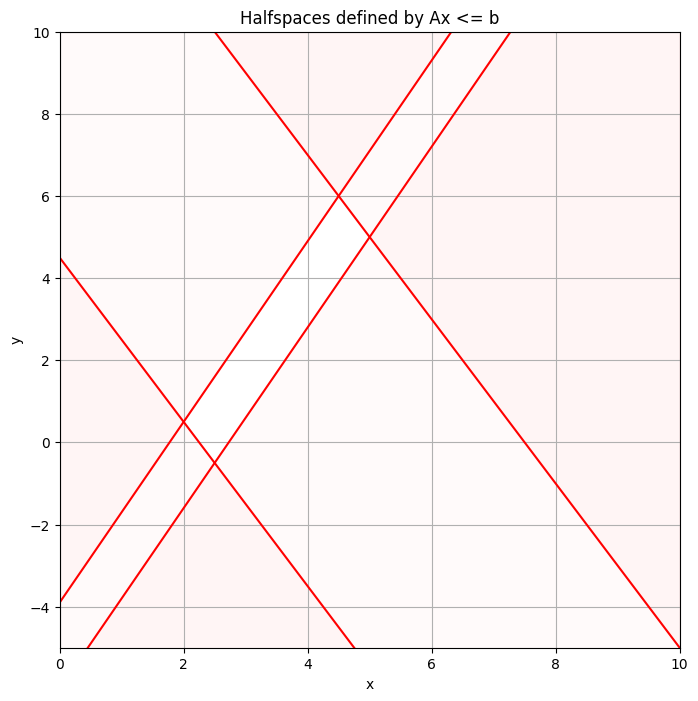

In [7]:
plot_halfspaces(Y_poly.A(), Y_poly.b())


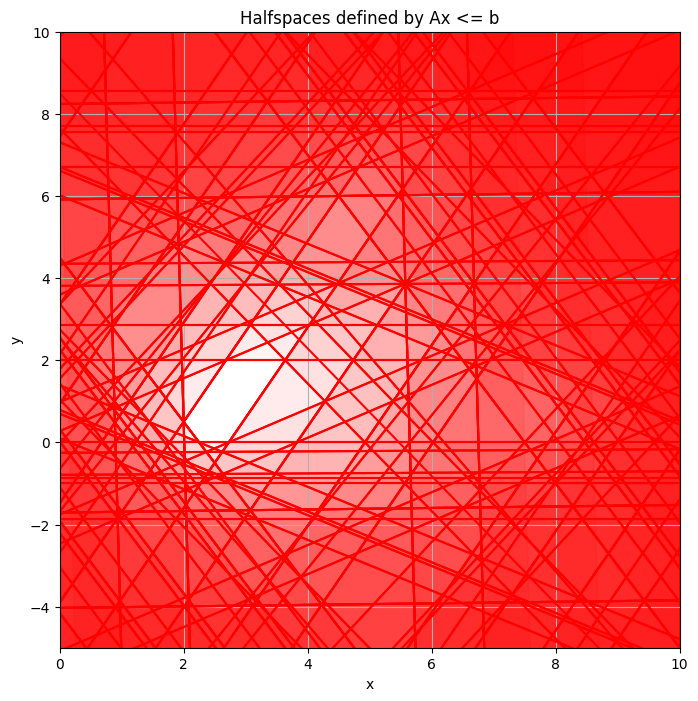

In [8]:
plot_halfspaces(Y_prime_poly.A(), Y_prime_poly.b())


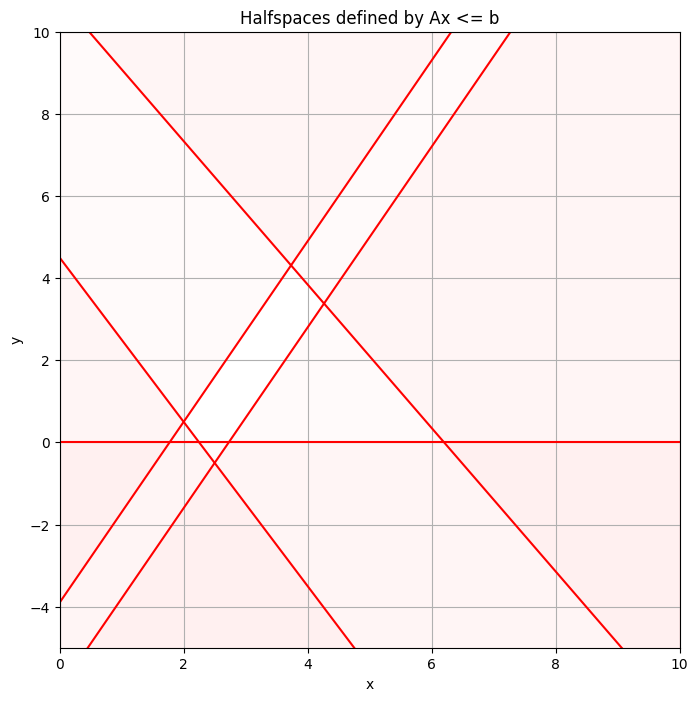

In [9]:
plot_halfspaces(Y_prime_reduced_poly.A(), Y_prime_reduced_poly.b())
